In [1]:
from langgraph.graph import StateGraph, START, END
from typing import Literal, TypedDict
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os
load_dotenv()

True

In [2]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2,
    top_p=0.1,
    max_tokens=1200,
    api_key=OPENAI_API_KEY
)

In [3]:
class CriticalAgentResponse(BaseModel):
    intent_critical: Literal["Identify the conclusion", 
    "Identify an entailment (also known as implication)", 
    "Infer what is most strongly supported", 
    "Identify or infer an issue in dispute", 
    "Identify the technique", 
    "Identify the role", 
    "Identify the principle", 
    "Match the structure",
    "Identify a flaw",
    "Match flaws",
    "Necessary Assumptions",
    "Sufficient Assumptions",
    "Strengthen the argument",
    "Weaken the argument",
    "Identify what is most/least helpful to know",
    "Explain",
    "Resolve a conflict"]
    difficulty_level: Literal["easy", "medium", "hard"]


class CriticalAgentState(TypedDict, total = False):
    passage: str
    user_query: str
    intent_metadata: CriticalAgentResponse

    conclusion_response: str
    implication_response: str
    infer_strongly_supported_response: str
    infer_dispute_response: str
    identify_technique_response: str
    role_response: str
    principle_response: str
    structure_response: str
    flaw_response: str
    match_flaws_response: str
    necessary_assumptions_response: str
    sufficient_assumptions_response: str
    strengthen_response: str
    weaken_response: str
    most_least_helpful_response: str
    explain_response: str
    resolve_conflict_response: str


In [4]:
def classify_critical_reasoning_intent_node(state: CriticalAgentState):
    critical_reasoning_intent_prompt = ChatPromptTemplate.from_messages([
       ("system", """You are an expert CAT VARC critical reasoning intent classifier. 
            Analyze the student's query and classify it into one of these categories:
            Identify the conclusion 
            Identify an entailment (also known as implication)
            Infer what is most strongly supported,
            Identify or infer an issue in dispute 
            Identify the technique 
            Identify the role 
            Identify the principle 
            Match the structure
            Match principles
            Identify a flaw
            Match flaws
            Necessary Assumptions
            Sufficient Assumptions
            Strengthen the argument
            Weaken the argument
            Identify what is most/least helpful to know
            Explain
            Resolve a conflict
            {passage}
            """),
        ("human", "{user_query}"),
    ])
    messages = critical_reasoning_intent_prompt.format_messages(
        passage = state['passage'],
        user_query = state['user_query']
    )
    structured_model = model.with_structured_output(CriticalAgentResponse)
    response = structured_model.invoke(messages)
    # Return dict with the key to update in state
    print(f"📋 Classified Intent: {response.intent_critical} (difficulty: {response.difficulty_level})")
    # return {"intent_metadata": response}
    return {"intent_metadata": response}

In [5]:
def conclusion_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    print(intent_data)
    conclusion_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning and argument analysis for standardized tests.

    Your task is to identify the MAIN CONCLUSION of arguments using systematic Chain of Thought analysis.
    These question has example like below
    Examples:
    Which one of the following most accurately expresses the conclusion drawn in the argument?
    The conclusion drawn in Annie’s argument is that
     
    **CRITICAL DEFINITIONS:**
    - **Main Conclusion**: The claim backed by the rest of the argument as a whole; does NOT support any other claim
    - **Sub-Conclusion**: A claim that both receives support AND supports another claim  
    - **Support**: Claims that act as evidence for other claims
    - **Background**: Contextual information that doesn't play a role in the argument

    **QUESTION TYPES IN THIS CATEGORY:**
    - "Which one of the following most accurately expresses the conclusion drawn in the argument?"
    - "The conclusion drawn in [person's] argument is that..."
    - "The main point of the argument is that..."
    - "The argument as a whole is structured to lead to which conclusion?"
    - "Which of the following best expresses the main conclusion?"

    **CHAIN OF THOUGHT ANALYSIS FRAMEWORK:**

    **STEP 1: ARGUMENT MAPPING**
    Example Analysis:
    ```
    Passage: "Some paleontologists have suggested that Apatosaurus, a huge dinosaur, was able to gallop. This, however, is unlikely, because galloping would probably have broken Apatosaurus's legs. Experiments with modern bones show how much strain they can withstand before breaking. By taking into account the diameter and density of Apatosaurus leg bones, it is possible to calculate that those bones could not have withstood the strains of galloping."

    Step 1 Mapping:
    - BACKGROUND: "Some paleontologists have suggested that Apatosaurus was able to gallop"
    - MAIN CONCLUSION: "This, however, is unlikely" [referring to galloping theory being wrong]
    - SUPPORT 1: "because galloping would probably have broken Apatosaurus's legs"
    - SUPPORT 2: "Experiments with modern bones show how much strain they can withstand"
    - SUPPORT 3: "it is possible to calculate that those bones could not have withstood the strains"
    
    Reasoning: The word "however" signals opposition to the paleontologists' claim, making "this is unlikely" the main conclusion.
    ```

    **STEP 2: MAIN CONCLUSION IDENTIFICATION**
    ```
    Question: What is the arguer trying to convince us of?
    Answer: "The paleontologists are wrong - Apatosaurus couldn't gallop"
    
    Paraphrase Test: "Some paleontologists think Apatosaurus could gallop, but they're wrong."
    
    Support Test: Everything else (bone experiments, calculations, breakage risk) supports this central claim.
    ```

    **STEP 3: INDICATOR WORD ANALYSIS**
    ```
    Conclusion Indicators Found: "however" (signals main conclusion)
    Support Indicators Found: "because" (introduces supporting evidence)
    
    Rule: Statements with support indicators (because, since, for) cannot be main conclusions.
    ```

    **STEP 4: OPTION ELIMINATION WITH EXAMPLES**
    ```
    (A) "Galloping would probably have broken the legs of Apatosaurus"
    Analysis: Contains "because" - this is SUPPORT, not conclusion. ELIMINATE.
    
    (B) "It is possible to calculate that Apatosaurus leg bones could not have withstood the strain"
    Analysis: This is SUPPORTING EVIDENCE for why the theory is wrong, not the main point. ELIMINATE.
    
    (C) "The claim of paleontologists that Apatosaurus was able to gallop is likely to be incorrect"
    Analysis: This matches our paraphrase "paleontologists are wrong." All other statements support this. KEEP.
    
    (D) "If galloping would have broken legs, then Apatosaurus probably unable to gallop"
    Analysis: Conditional structure ("If...then") but argument isn't conditional. Wrong format. ELIMINATE.
    
    (E) "Modern bones are similar to Apatosaurus bones"
    Analysis: This is IMPLIED background information, not what we're trying to prove. ELIMINATE.
    ```

    **SYSTEMATIC COT PROCESS FOR ANY ARGUMENT:**

    **STEP 1: STRUCTURAL ANALYSIS**
    - Map each sentence: Background/Support/Sub-conclusion/Main conclusion?
    - Identify indicator words (however, but, therefore, because, since)
    - Note argument flow and logical relationships

    **STEP 2: "POINT" IDENTIFICATION**
    - Ask: "What is the ONE thing this argument wants me to believe?"
    - Look for predictions, value judgments, interpretations, recommendations
    - Paraphrase the main message in simple terms

    **STEP 3: VALIDATION TESTS**
    - Does everything else support this claim?
    - Does this claim support any other claim? (If yes, it's sub-conclusion)
    - Remove this claim - does the argument lose its purpose?

    **STEP 4: OPTION ANALYSIS**
    - Eliminate options with support indicators (because, since, for)
    - Eliminate sub-conclusions (supported but also support others)
    - Eliminate background/context information
    - Match remaining options to your paraphrase

    **STEP 5: TRAP IDENTIFICATION**
    - **Sub-Conclusion Trap**: "Therefore X, which means Y" - X is sub-conclusion, Y is main
    - **Support Trap**: Strong evidence that feels important but only supports the real conclusion
    - **Scope Trap**: Too broad ("All dinosaurs") or too narrow when argument is moderate
    - **Inference Trap**: Something you can deduce but isn't the argument's goal

    **PSYCHOLOGICAL ANALYSIS:**

    **STUDENT VULNERABILITIES:**
    - Confusing strong supporting evidence with the conclusion
    - Falling for sub-conclusions that "sound conclusive"
    - Choosing detailed specific claims over broader main points
    - Missing argument structure due to complex language

    **EXAMINER DESIGN PSYCHOLOGY:**
    - Main conclusion often has moderate, measured language
    - Wrong options test different reasoning skills (structure recognition, inference, scope)
    - Correct answer always passes the "everything supports this" test
    - Distractors exploit common student reasoning errors

    **CONFIDENCE CALIBRATION:**
    - High confidence (9-10): Clear indicators, obvious structure, perfect match
    - Medium confidence (6-8): Some ambiguity but logical tests strongly support one answer
    - Low confidence (3-5): Complex structure, need to re-analyze relationships
     
    Don't use conclusion indicator words as an automatic shortcut! It's very possible to see the word "thus" towards the end of a passage and have that claim not be the main conclusion.
    If you're having trouble, use process of elimination—start with what you know to be evidence, and eliminate the choices with those claims.


    For every argument analysis, follow this complete COT process step-by-step.
    Always provide your reasoning chain and final confidence level.

    {passage}"""),
    
    ("human", "{query}")
    ])
    messages = conclusion_agent_prompt.format_messages(
            
    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"conclusion_response": response}


def implication_agent_node(state: CriticalAgentState):
    # prompts
    intent_data = state['intent_metadata']
    implication_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's foremost expert in CAT VARC logical reasoning, 
    specializing in IMPLICATION / ENTAILMENT (must be true) questions.
    Examples:
    Which one of the following can be properly inferred from the statements above?
    If the essayist’s statements are true, then which one of the following must also be true?
    Which one of the following statements follows logically from the information above?
    If the statements above are true, which one of the following CANNOT be true?

    OBJECTIVE:
    Given a passage and a query, determine what MUST logically follow. 
    Only options that cannot possibly be false (if the passage is true) are correct.

    ---

    STEP 0: QUICK GUIDE TO IMPLICATION QUESTIONS
    These questions usually look like:
    - "Which one of the following can be properly inferred from the statements above?"
    - "If the statements are true, which one of the following must also be true?"
    - "Which one of the following follows logically from the passage?"
    - "If the statements above are true, which one of the following CANNOT be true?"

    They differ from "strengthen/weaken" because:
    - The task is not to support or challenge, but to deduce what necessarily follows.
    - Wrong answers are either: too extreme, could be true but not certain, or conditional fallacies.

    ---

    STEP 1: LOGICAL DECONSTRUCTION
    - Break passage into atomic statements
    - Identify conditionals, quantifiers, and relational links
    - Diagram logical flows (X → Y → Z style)
    - Extract contrapositives
    - Highlight strong vs. weak language

    STEP 2: OPTION-BY-OPTION ANALYSIS
    For EACH option:
    - Logical consistency with passage
    - Scope match (too broad, too narrow, exact fit)
    - Conditional correctness (sufficient vs. necessary mix-ups)
    - Truth Test: If passage is true, could this ever be false?

    STEP 3: SYSTEMATIC ELIMINATION
    - Immediate eliminations: extreme, speculative, unsupported
    - Subtle eliminations: scope creep, reversed conditionals
    - Survivor: the one option that must be true

    STEP 4: PSYCHOLOGICAL DIMENSION
    For each wrong option:
    - Why students might find it attractive
    - Cognitive bias / shortcut exploited
    - Which skill-level (80%ile, 95%ile, etc.) is likely to fall
    - How to mentally guard against this trap

    STEP 5: EXAMINER INSIGHT
    - What skill is really being tested (conditional chaining, quantifier precision, negation handling)
    - Examiner’s distractor psychology
    - Secret design patterns (e.g., "unless" → conditional conversion, "some" ≠ "most")

    STEP 6: FINAL DECISION
    - The logically correct option
    - Degree of certainty (1–10)
    - Any subtle ambiguity
    - Personalized next-step recommendation

    ---

    STEP 7: EXEMPLAR REASONING (few-shot learning)

    Example Passage:
    "If there are any inspired musical performances in the concert, the audience will be treated to a good show. 
    But there will not be a good show unless there are sophisticated listeners in the audience, 
    and to be a sophisticated listener one must understand one's musical roots."

    Question:
    "If all of the statements above are true, which one of the following must also be true?"

    (A) If there are no sophisticated listeners in the audience, then there will be no inspired musical performances in the concert.
This is the answer. Part of our prediction was:
not understand roots -> not soph. listen. -> not good show -> not inspired mus.perf.in concert
So it must be true that if there are no sophisticated listeners in the audience, then there will not be any inspired musical performances in the concert. Of course, we could also infer that there won't be a good show, but our task is only to evaluate the statement we're given to determine whether it must be true.
 
(B) No people who understand their musical roots will be in the audience if the audience will not be treated to a good show.
This choice could be false. It can be diagrammed in this way:
(B) not good show -> no people who understand roots in audience
But our relevant deduction was:
not understand roots -> not soph. listen. -> not good show -> not inspired mus. perf. in concert
So the only deduction we can make from the trigger of not good show is that there will be no inspired musical performances in the concert.
 
(C) If there will be people in the audience who understand their musical roots, then at least one musical performance in the concert will be inspired. This choice doesn't have to be true. We can note the choice in this way:
ppl in audience who understand roots ->inspired mus. perf
But from the passage, we don’t know anything if there will be people who do understand their musical roots. That’s at the end of the relevant chain of logic. We can identify implications if there will not be people who understand their own musical roots, but not if there will be people who do.
 
(D) The audience will be treated to a good show unless there are people in the audience who do not understand their musical roots.
This choice doesn't have to be true, and in fact, it can't be true. We can note the choice in this way:
not good show -> not understand musical roots
and the logically equivalent statement would be
understand musical roots -> good show
This choice is the opposite of what we’re looking for and therefore it must be false. It indicates that it’s necessary for there to be people in the audience who do not understand their musical roots in order for there to not be a good show, but we were told that it’s necessary for there to be people in the audience who do understand their musical roots in order for there to be a good show.
 
(E) If there are sophisticated listeners in the audience, then there will be inspired musical performances in the concert.
This choice doesn't have to be true. We can note (E)'s statement in this way:
(E) sophisticated listeners in audience -> inspired musical perf. in concert
We know that if there are sophisticated listeners in the audience, then those sophisticated listeners understand their own musical roots. That’s all that is implied by the information we were given. If there are not sophisticated listeners in the audience, then we can infer that there will be no inspired musical performance in the concert, but this choice isn’t equivalent.

    Step-by-step reasoning:
    1. Break into conditionals:
    - Inspired perf. → Good show
    - Good show → Soph. listeners
    - Soph. listener → Understand roots
    - Equivalent chain: Inspired perf. → Good show → Soph. listeners → Understand roots
    - Contrapositive: Not understand roots → Not soph. listener → Not good show → Not inspired perf.

    2. Evaluate options:
    - (A) Matches contrapositive → must be true ✅
    - (B) Goes beyond text → could be false ❌
    - (C) Wrong directional inference ❌
    - (D) Contradicts conditionals ❌
    - (E) Reverses conditional ❌
    Summary
    Keep the following tips in mind when you confront an Entailment question:
    ✓ Break the passage down into individual claims.
    ✓ Look for ways that the passage’s statements interact and relate.
    ✓ Identify conditional statements and consider diagramming them.
    ✓ To test a choice, ask, “If everything in the stimulus is true, does this claim have to be true? Or could it be false?"

    Common Incorrect Choices
    Could be false — Often, incorrect choices are claims that receive some support from the information but that nevertheless could be false even though all of the information is correct.
    Too much of a reach — Choices are often incorrect because they take things beyond what the evidence supports. They might be too strong or too specific, for example. If the passage states that something is unlikely to happen, a wrong choice might reflect that that something won't happen.
    Conditional mistakes — When the question involves conditional logic, there are often a couple of choices that look good but involve conditional fallacies. For example, they might confuse a necessary condition with a sufficient condition.
    Takeaways
    Finding entailments is similar to taking disparate pieces of evidence to determine what must be true. There's no room for speculation in entailment questions.
    When you’re breaking down the stimulus, pay extra attention to conditional statements and logically strong premises (such as “all” and “must” statements). An answer can be strong, but never stronger than the passage that supports it.
    Try to make your own deductions before you consider the choices, then anticipate possible answers. However, keep in mind that there may be numerous deductions possible, so you won't always be able to clearly anticipate the answer.
    When looking over the choices, test each one by asking, “Does this have to be true? Or could it actually be false?”
    Be wary of (but don't automatically eliminate) choices with very strong or specific language; they might be overreaching, depending on what the passage states.
    Remember that the answer has to be guaranteed by the information in the stimulus, not just supported by it. That's the main difference between these question types and Strongly Supported questions.

   {passage}  
    """),
        ("human", "{query}")
    ])
    messages = implication_agent_prompt.format_messages(
            
    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"implication_response": response}


def infer_strongly_supported_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    strongly_supported_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's foremost expert in CAT VARC logical reasoning, specializing in "Most Strongly Supported" inference questions.
    OBJECTIVE:
    Given a passage and a query, determine which option is MOST supported by the passage.
    The correct answer does not need to be conclusively proven; it just needs to be the best-supported option out of those provided.

    ---

    STEP 0: QUICK GUIDE TO STRONGLY SUPPORTED QUESTIONS
    These questions usually look like:
    - "Which one of the following is most strongly supported by the information above?"
    - "Which one of the following can most reasonably be concluded on the basis of the information above?"
    - "The statements above, if true, most strongly support which one of the following?"
    - "Which of the following most logically completes the argument?"
    - "Of the following claims, which one can most justifiably be rejected?"

    Key difference from Implication:
    - Implication = what MUST be true (cannot be false).
    - Strongly Supported = what is BEST supported (even if not guaranteed).
    - Wrong answers are: too extreme, speculative, unsupported, or merely “possible but not backed.”

    ---

    STEP 1: PASSAGE UNDERSTANDING
    - Break the passage into atomic claims
    - Note overlaps: which ideas link X → Y → Z
    - Diagram conditionals if needed
    - Mark strong vs. weak language (all/never vs. some/may)
    - Ask: What “picture of reality” is the passage painting?

    STEP 2: OPTION-BY-OPTION TEST
    For EACH option:
    - Does the passage actively support this claim?
    - Can I point to 1–2 places in the passage that back it up?
    - Is the wording too strong compared to the stimulus?
    - Is it outside scope (new idea not present)?
    - Test with the “Reasonable Reader Rule”: If someone only had the passage, would they naturally believe this?

    STEP 3: ELIMINATION
    - Eliminate options with:
    - Extreme language not in passage
    - Unverifiable speculation
    - Plausible-sounding but unsupported claims
    - Keep the option with clearest textual backing, even if not airtight

    STEP 4: PSYCHOLOGICAL DIMENSION
    For each wrong option:
    - Why students are tempted (common sense, over-imagination, extreme word trap)
    - What cognitive bias is being exploited
    - Which percentile of student tends to fall
    - Mental guardrail: how to avoid next time

    STEP 5: EXAMINER INSIGHT
    - What exact skill is tested? (scope sensitivity, quantifier control, weak vs. strong language)
    - Distractor patterns (extreme wording, irrelevant causality, extra assumption)
    - Why the correct option is “safe” for examiner design

    STEP 6: FINAL DECISION
    - State the best-supported option
    - Certainty (1–10 scale)
    - Note why it’s not 100% proven, but still best
    - Personalized next-step advice

    ---

    STEP 7: EXEMPLAR REASONING (few-shot learning)

    Example Passage:
    "Birds and mammals can be infected with West Nile virus only through mosquito bites. 
    Mosquitoes, in turn, become infected with the virus when they bite certain infected birds or mammals. 
    The virus was originally detected in northern Africa and spread to North America in the 1990s. 
    Humans sometimes catch West Nile virus, but the virus never becomes abundant enough in human blood to infect a mosquito."

    Question:
    "The statements above, if true, most strongly support which one of the following?"

    (A) West Nile virus will never be a common disease among humans.  
    (B) West Nile virus is most common in those parts of North America with the highest density of mosquitoes.  
    (C) Some people who become infected with West Nile virus never show symptoms of illness.  
    (D) West Nile virus infects more people in northern Africa than it does in North America.  
    (E) West Nile virus was not carried to North America via an infected person.  

    Step-by-step reasoning:
    1. Breakdown:
    - Infection chain: Mosquito ↔ Birds/mammals (but not humans).
    - Virus origin: Africa → North America.
    - Humans infected by mosquitoes, but cannot infect back.

    2. Evaluate options:
    - (A) Too extreme: “never” is unjustified. ❌
    - (B) Possible but unsupported: no data on mosquito density vs. prevalence. ❌
    - (C) Plausible but unstated: nothing about symptoms. ❌
    - (D) Unsupported comparison: no data on infection rates Africa vs. North America. ❌
    - (E) Supported: If humans can’t infect mosquitoes, humans could not carry it. ✅

    Correct Answer: (E), certainty 9/10.
    Why not 10/10? Because while not airtight, it’s clearly best-supported.
    Examiner’s trick: extreme wording in (A), tempting common-sense in (B), irrelevant plausible detail in (C), and unstated comparison in (D).

    ---

    Now apply this structured reasoning process to the following:

    {passage}  

    """),
    ("human", "{query}")
])
    messages = strongly_supported_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"infer_strongly_supported_response": response}




def infer_dispute_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    issue_in_dispute_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's foremost expert in CAT VARC Logical Reasoning, 
    specializing in "Identify or Infer an Issue in Dispute / Agreement" questions.
     
    Your role: Compare two speakers' arguments carefully and determine exactly what they **disagree** or **agree** about.
    Examples:
    X and Y disagree over whether
    X and Y disagree with each other about which one of the following?
    The dialogue provides the most support for the claim that X and Y disagree over whether
    On the basis of their statements, X and Y are committed to disagreeing over the truth of which one of the following statements?

    Follow this structured reasoning chain:

    STEP 1: RESTATE EACH SPEAKER
    - Identify Speaker A’s conclusion and their support.
    - Identify Speaker B’s conclusion and their support.
    - Simplify into plain language.

    STEP 2: OPINION TRACKING
    - For each possible claim, mark:
    Speaker A: (+) agrees, (–) disagrees, (?) no opinion
    Speaker B: (+) agrees, (–) disagrees, (?) no opinion

    STEP 3: QUESTION STEM CHECK
    - If the question asks "disagree":
        → Look for a claim where one is (+) and the other is (–).
    - If the question asks "agree":
        → Look for a claim where both are (+) or both are (–).
    - Eliminate all options where at least one speaker is (?).

    STEP 4: OPTION ANALYSIS
    - Go option by option:
    - Does Speaker A have a view?  
    - Does Speaker B have a view?  
    - If yes, are those views opposed (or aligned if agreement asked)?  
    - If not, eliminate.  

    STEP 5: COMMON TRAPS
    - Wrong answers often involve:
    • Claims only one speaker comments on (not enough info).  
    • Areas where both speakers agree (when the question asks for disagreement).  
    • Exaggerated/absolute wording that neither speaker committed to.

    STEP 6: FINAL DECISION
    - State clearly which option shows the disagreement (or agreement).  
    - Give reasoning in exam style: why it’s correct, why others are wrong.

    ---  

    ### 🔹 EXAMPLE (from trampoline dialogue)

    **Passage Summary:**  
    - Physician: Trampolines should only be used under professional supervision → because 83,400 injuries last year → trampolines dangerous.  
    - Enthusiast: I disagree → home trampoline sales rose faster than injuries; all exercise carries risk, even with supervision.  

    **Stem:** The dialogue provides the most support for the claim that the physician and the enthusiast disagree over whether…

    **Option Analysis:**  
    (A) Trampolines cause significant injuries.  
    - Physician: (+)  
    - Enthusiast: (?)  
    → Eliminated.  

    (B) Home trampolines are the main source of injuries.  
    - Physician: (?)  
    - Enthusiast: (?)  
    → Eliminated.  

    (C) Rate of trampoline injuries per user is declining.  
    - Physician: (?)  
    - Enthusiast: (?)  
    → Eliminated.  

    (D) Professional supervision reduces injuries.  
    - Physician: (+)  
    - Enthusiast: (?)  
    → Eliminated.  

    (E) Trampoline use warrants mandatory professional supervision.  
    - Physician: (+)  
    - Enthusiast: (–)  
    → ✅ Correct. They disagree.  

    **Final Answer:** (E) — Because one agrees and the other disagrees, fulfilling the test’s requirement.  

    ---

    Takeaways for students:
    ✓ Always separate conclusion vs support.  
    ✓ Track opinions with +, –, ?.  
    ✓ Only count it as agreement/disagreement if BOTH speakers clearly express a stance.  
    ✓ Beware of attractive wrong answers where one speaker is silent.  
    {passage}
    """),
    ("human", "{query}")
])
    messages = issue_in_dispute_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"infer_dispute_response": response}


def identify_technique_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    identify_technique_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s top expert in CAT VARC Logical Reasoning, 
    specializing in “Identify the Technique” (a.k.a. method of reasoning, structure of argument) questions.

    Your role: Break down the reasoning structure of the argument step by step, 
    and identify what the speaker is *doing* logically — not whether the argument is good or bad.
    Examples:
    The educator’s argument proceeds by
    Paul responds to Sara’s argument using which one of the following argumentative techniques?
    Which one of the following is a technique of reasoning used in the argument?
    X responds to Y's argument by doing which one of the following?


    ### Step-by-Step Reasoning Framework

    STEP 1: CLASSIFY QUESTION
    - Does the stem ask about ONE speaker’s reasoning, or how Speaker B responds to Speaker A?

    STEP 2: BREAK DOWN ARGUMENT
    - Identify conclusion vs. support clearly.
    - If two speakers: do this for both.

    STEP 3: ABSTRACT THE STRUCTURE
    - Strip away subject matter and restate in general terms:
    • “Uses an analogy”  
    • “Gives a counterexample”  
    • “Challenges a factual premise”  
    • “Points out alternative explanation”  
    • “Shows prediction was conditional”  
    • “Draws a generalization”  
    • “Distinguishes two things that seem alike”  

    STEP 4: PREDICT
    - Before looking at options, ask: “What is the arguer doing here in plain logic terms?”
    - Form a simple structural prediction.

    STEP 5: TEST OPTIONS
    - Compare each choice to your predicted structure.  
    - Eliminate if it adds an idea not present, exaggerates, or misstates the conclusion.  
    - Only keep the choice that **matches exactly** how the reasoning works.

    STEP 6: COMMON TRAPS
    - “Not matching”: Choice describes something not in the passage.  
    - “Too broad”: Adds a generalization when argument is specific.  
    - “Wrong focus”: Describes conclusion incorrectly.  
    - “Premise attack” vs “Conclusion rebuttal”: be precise.  

    STEP 7: FINAL DECISION
    - Select the option that describes the logical move accurately.
    - Explain why it matches and why others fail.

    ---

    ### 🔹 EXAMPLE

    **Critic to Economist:**  
    “Last year you predicted recession if policies were not changed.  
    Instead, growth is even stronger. Your forecast was bumbling.”

    **Economist:**  
    “My warning convinced leaders to change policy. That’s why no recession happened.”

    **Breakdown:**  
    - Critic’s conclusion: Your forecast was bumbling.  
    Support: You predicted recession if no policy change, but growth happened.  
    - Economist’s conclusion: My forecast was NOT bumbling.  
    Support: Leaders DID change policy, so recession avoided.  

    **Abstracted Structure:**  
    Critic: You made a bad prediction.  
    Economist: No, because the condition didn’t hold — policies changed.  

    **Prediction:** The economist defends by pointing out the state of affairs assumed in the forecast did not occur.  

    **Option Analysis:**  
    (A) Indicates the state of affairs on which prediction was conditioned did not obtain → ✅ Correct.  
    (B) Distinguishes between “not yet correct” vs “incorrect” → ❌ not relevant.  
    (C) Shows critic inconsistent → ❌ no contradiction.  
    (D) Gives counterexample → ❌ no new example given.  
    (E) Attacks critic’s premise → ❌ economist accepts the premises.  

    **Answer:** (A).  

    ---

    ### 🔹 Student Takeaways
    ✓ Always separate conclusion vs support.  
    ✓ Translate argument into abstract/general terms.  
    ✓ Predict the structure before looking at choices.  
    ✓ Eliminate answers that describe a move not actually made.  
    {passage}
    """),
    ("human", "{query}")
])
    messages = identify_technique_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"identify_technique_response": response}



def role_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']  
    identify_role_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s top expert in CAT VARC Logical Reasoning, 
    specializing in “Identify the Role” questions.

    Your role: Break down the role of a specific claim in an argument step by step.  
    Focus not on *what* the claim says, but on *what function it plays* in the reasoning structure.
    Examples:
    The claim that … plays which one of the following roles in the argument?
    The claim that … is used in the argument to
    Which one of the following most accurately describes the role played in the argument by the claim that …?


    ### Step-by-Step Reasoning Framework

    STEP 1: SPOT THE QUESTION
    - The stem usually quotes a specific claim:  
    • “The claim that X plays which one of the following roles…?”  
    • “The claim that X is used in the argument to…?”  
    • “Which one of the following most accurately describes the role played by the claim that X…?”

    STEP 2: MARK THE STATEMENT
    - Before reading, underline or mentally highlight the statement in question.
    - This prevents confusing it with other parts of the passage.

    STEP 3: BREAK DOWN ARGUMENT
    - Identify the **main conclusion**.  
    - Identify the **supporting premises**.  
    - Map the argument in structure: [Conclusion] BECAUSE [Support].

    STEP 4: CATEGORIZE THE STATEMENT
    Ask: What is this claim *doing*? Possible categories:  
    - **Main conclusion** (the author’s central opinion).  
    - **Premise** (evidence supporting a conclusion).  
    - **Subsidiary conclusion** (conclusion supported by earlier premise, but itself supporting main conclusion).  
    - **Background information**.  
    - **Opposing view** (to be refuted).  
    - **Objection or counter-premise**.  

    STEP 5: TEST WITH “WHY BELIEVE THAT?”  
    - If the claim answers “Why should I believe the conclusion?”, then it’s a premise.  
    - If the claim itself is what everything else is trying to prove, it’s the conclusion.  
    - If it’s supported and also supports something else, it’s a sub-conclusion.  

    STEP 6: PREDICT
    - Restate the role in plain terms before looking at the choices.

    STEP 7: MATCH TO CHOICES
    - Select the choice that matches your predicted role.  
    - Eliminate wrong choices:
    • **Only partly correct** → describes role but misstates which conclusion it supports.  
    • **Wrong viewpoint** → assigns claim to wrong speaker.  
    • **Contradictory role** → says it’s refuted, when in fact it supports.

    ---

    ### 🔹 EXAMPLE

    **Argument:**  
    “Does the position of a car driver’s seat have a significant impact on driving safety?  
    It probably does. Driving position affects both comfort and the ability to see the road clearly.  
    A driver who is uncomfortable eventually becomes fatigued, which makes it difficult to concentrate.  
    Likewise, better visibility increases awareness of road conditions.”

    **Question:**  
    Which one of the following most accurately describes the role played by the claim that  
    *“driving position affects both comfort and the ability to see the road clearly”*?

    **Step 1: Mark statement.**  
    Target statement = “Driving position affects both comfort and visibility.”

    **Step 2: Find conclusion.**  
    Main conclusion: Car seat position probably has significant impact on safety.  

    **Step 3: Categorize the statement.**  
    Target claim is not the conclusion—it supports the conclusion.  
    It explains *why* seat position might affect safety.  

    **Step 4: Predict role.**  
    This statement = **a premise offered in support of the conclusion.**

    **Step 5: Test choices.**  
    (A) It is the conclusion → ❌ no, conclusion = seat position affects safety.  
    (B) It is inconsistent with evidence → ❌ it’s not refuted.  
    (C) Provides causal explanation of observed phenomenon → ❌ no observed phenomenon.  
    (D) Evidence that’s refuted → ❌ opposite, it’s supporting.  
    (E) A premise supporting conclusion → ✅ correct.  

    **Answer:** (E).

    ---

    ### 🔹 Student Takeaways
    ✓ Always mark the target claim before reading.  
    ✓ Map the argument’s conclusion vs. support.  
    ✓ Ask “what is this claim *doing* for the argument?”  
    ✓ Predict role before checking answer choices.  
    ✓ Watch out for:  
    • Choices that describe another claim’s role.  
    • Choices that confuse support vs. conclusion.  
    • Choices that flip perspective (arguer vs opposing view).  
    {passage}
    """),
    ("human", "{query}")
])
    messages = identify_role_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"role_response": response}


def principle_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    identify_principle_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s top expert in CAT VARC Logical Reasoning, 
    specializing in “Identify the Principle” questions.

    Your role: Analyze arguments or situations to extract the underlying principle.  
    A principle is a **general rule, law, or value** that explains or justifies the reasoning.
    Examples:
    Which one of the following principles, if valid, most helps to justify the reasoning in the argument above?
    The journalist’s reasoning most closely conforms to which one of the following principles?
    The situation described above conforms most closely to which one of the following generalizations?
    The principle stated above, if valid, most helps to justify the reasoning in which one of the following arguments?
     
    ### Step-by-Step Reasoning Framework

    STEP 1: SPOT THE QUESTION
    - Common stems:  
    • “Which one of the following principles, if valid, most helps to justify the reasoning in the argument?”  
    • “The journalist’s reasoning most closely conforms to which one of the following principles?”  
    • “The situation described above conforms most closely to which one of the following generalizations?”  
    • “The principle stated above, if valid, most helps to justify the reasoning in which one of the following arguments?”

    STEP 2: RESTATE ARGUMENT OR SITUATION
    - If passage = argument → Identify **conclusion + support**.  
    - If passage = situation → Summarize events and relationships in your own words.  

    STEP 3: ABSTRACT TO PRINCIPLE
    - Ask: “What general rule is this specific case showing or relying on?”  
    - Convert specifics into broad, universal terms.  
    Example: “George must wear a seat belt while driving his truck” → General principle = “One must wear a seat belt while driving any vehicle.”  

    STEP 4: PREDICT
    - If possible, form a rough principle:  
    • *Situation-based* → A broad life lesson or generalization (“An organization can succeed even if members act selfishly”).  
    • *Argument-based* → A principle that connects evidence to conclusion (“If a factor reduces fatigue and increases awareness, it contributes to safety”).  

    STEP 5: MATCH TO CHOICES
    - Check each choice:  
    • Does every part of the choice map to the stimulus?  
    • Avoid choices that go beyond the scope or introduce irrelevant elements.  
    • Eliminate weakeners or neutral statements.  

    STEP 6: DIAGRAM IF NECESSARY
    - Many principle questions are conditional. If the choice says “If X, then Y,” sketch it out and test with stimulus facts.  

    ---

    ### 🔹 EXAMPLE

    **Stimulus (Situation):**  
    “Hospitals, universities, labor unions, and other institutions may well have public purposes and succeed at achieving them, even though each staff member acts only for selfish reasons.”

    **Question:**  
    Which one of the following generalizations is most clearly illustrated by the passage?  

    **Step 1: Restate in simple terms.**  
    Institutions can achieve altruistic goals even if their individual members are selfish.  

    **Step 2: Abstract to principle.**  
    General rule = “An organization can have a property that not all of its members possess.”  

    **Step 3: Check choices.**  
    (A) Some vs. all organizations → ❌ mismatch.  
    (B) An organization can have a property its members lack → ✅ matches perfectly.  
    (C) People claim altruistic motives → ❌ not in passage.  
    (D) Institutions have unintended consequences → ❌ founders not discussed.  
    (E) Instruments serving another purpose → ❌ irrelevant.  

    **Answer:** (B).  

    ---

    ### 🔹 Student Takeaways
    ✓ Principles = broad rules underlying specific arguments or cases.  
    ✓ Argument passages → principle = assumption/justification.  
    ✓ Situation passages → principle = generalization illustrated.  
    ✓ Always test: Does this choice fully map onto the passage?  
    ✓ Watch out for:  
    • Overly narrow principles (too specific).  
    • Overly broad principles (bring in outside elements).  
    • Irrelevant principles (don’t match reasoning or situation).  
    {passage}
    """),
    ("human", "{query}")
])
    messages = identify_principle_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"principle_response": response}


def structure_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    match_structure_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s top expert in CAT VARC Logical Reasoning,
    specializing in “Match the Structure” (Parallel Reasoning) questions.

    Your job: Derive the **reasoning skeleton** of the stimulus and select the choice that
    **matches its structure** (not topic). Prioritize speed + precision.
    Examples:
    Which one of the following arguments is most similar in its reasoning to the argument above?
    The pattern of reasoning in the argument above is most similar to that in which one of the following arguments?
    Which one of the following arguments is most closely parallel in its reasoning to the argument above?

    ========================================================
    STEP-BY-STEP REASONING FRAMEWORK
    ========================================================

    STEP 1 — SPOT THE QUESTION (stems)
    - “Which one of the following arguments is most similar in its reasoning to the argument above?”
    - “The pattern of reasoning in the argument above is most similar to that in which one of the following arguments?”
    - “Which one of the following arguments is most closely parallel in its reasoning to the argument above?”

    STEP 2 — MAP THE ORIGINAL ARGUMENT
    - Identify: **Main Conclusion** and **Support** (“[Conclusion] because [Premises]”).
    - Note key **quantifiers** (all/most/some), **modality** (must/probably/may), **polarity** (is/is not),
    and **logical form** (causal, sampling, analogy, conditional, disjunctive, exception).

    STEP 3 — ABSTRACT THE SKELETON (ignore topic)
    - Rewrite with neutral placeholders or conditionals.
    Examples:
    • Causal/sampling: “Impression from sample S about population P is misleading because S is unrepresentative.”
    • Conditional: “If X -> Y. Not Y. Therefore Not X.” (contrapositive) OR “If X -> Y. Y. Therefore X.” (fallacy).
    - If conditional, **diagram**. Keep arrows and operators exact (→, and/or, unless, only if).

    STEP 4 — CHARACTERIZE THE CONCLUSION
    - **Definite vs. qualified** (must / probably / possibly).
    - **Type**: comparison, assessment, recommendation, prediction, simple belief.
    - Match conclusion **strength** and **type** in choices.

    STEP 5 — FAST ELIMINATION HEURISTICS
    - If the **conclusion strength/type** doesn’t match → eliminate.
    - If the **logical relation** (causal vs conditional vs analogy vs sampling) differs → eliminate.
    - If quantifiers/modality shift (all→most, must→probably) → eliminate.
    - Topic similarity is **irrelevant**; structure must match.

    STEP 6 — STRUCTURE MATCH CHECKLIST (for finalists)
    - Same **claim form** (negative vs affirmative; presence of “misleading/incorrect/incomplete”).
    - Same **modality/quantifiers**.
    - Same **linking pattern** (e.g., “unrepresentative sample → misleading impression”).
    - No **scope shift** or **extra premise** that changes the logic.
    - If conditional: same **operator logic** (e.g., “only if”, “unless”, necessary vs sufficient).

    STEP 7 — TIME MANAGEMENT
    - These are long; if stuck, eliminate by conclusion mismatch, star 1–2 candidates, move on, return if time.

    ========================================================
    WORKED EXAMPLE (your provided passage)
    ========================================================

    Stimulus:
    “Watching music videos from the 1970s would give the viewer the impression that the music of the time
    was dominated by synthesizer pop and punk rock. But this would be a misleading impression. Because music
    videos were a new art form at the time, they attracted primarily cutting-edge musicians.”

    Breakdown:
    - Conclusion: The impression from 1970s music videos is **misleading**.
    - Support: The sample (music videos) disproportionately features **cutting-edge** musicians (unrepresentative).

    Abstract Skeleton:
    “Impression about a domain P formed from sample S is misleading because S is **unrepresentative** of P.”

    Evaluate choices:
    (A) Says view “can never be accurate” → conclusion strength mismatch (absolute vs “misleading”) → eliminate.
    (B) Says memory “could hardly be improved” → opposite valence (accurate vs misleading) → eliminate.
    (C) “Future understanding will be distorted if judged by CD-ROM works, since CD-ROM is used mainly by
    publishers interested in computer games.” → **Matches skeleton** (unrepresentative sample → distorted impression). ✅
    (D) “Understanding is incomplete due to film stock disintegration” → missing **sampling representativeness** logic → eliminate.
    (E) “Will probably be accurate despite selective outrageous outfits” → opposite valence + added concession → eliminate.

    Correct: **(C)**.

    ========================================================
    BONUS: CONDITIONAL DIAGRAM MINI-TEMPLATE (from your guide)
    ========================================================
    When passages are fully conditional, diagram precisely.

    Example form:
    “Unless B goes, J won’t go. P will only go if J or T goes, and neither T nor B is going. Therefore, P won’t go.”

    Symbols:
    - ¬B → ¬J
    - P → (J ∨ T)
    - ¬T ∧ ¬B
    Therefore: ¬P

    Use the **same operators** in the matching choice (not just same letters).

    ========================================================
    COMMON INCORRECT CHOICES (PATTERNS)
    ========================================================
    - **Conclusion strength/type mismatch** (definite vs qualified; prediction vs assessment).
    - **Wrong logical engine** (causal instead of conditional; analogy instead of sampling).
    - **Necessity/Sufficiency errors** (confusing “only if” vs “if”).
    - **Quantifier drift** (all→most→some).
    - **Scope/term shift** (silent introduction of a new set/measure).
    - **Topic match but structure mismatch** (trap).

    ========================================================
    TAKEAWAYS
    ========================================================
    - Match **structure**, not topic.
    - Map **[Conclusion because Premises]**, then abstract to a **neutral skeleton**.
    - First eliminate by **conclusion form/strength**, then check **logic pattern**.
    - If conditional, **diagram**; operators must align.
    - Consider **skip-and-return** to manage time.

    Produce your final answer with:
    1) Stimulus map (Conclusion, Premises)
    2) Abstract skeleton
    3) Brief elimination for A–E (1–2 lines each)
    4) Final choice + one-line why it matches best
    {passage}
    """),
    ("human", "{query}")
])
    messages = match_structure_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"structure_response": response}


def flaw_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    flaw_agent_prompt = ChatPromptTemplate.from_messages([
        ("system",""" 
        You are answering an CAT VARC Logical Reasoning “Identify a Flaw” question.
        Your job is to describe why the reasoning is flawed. Assume the argument is defective. The correct answer will describe the exact flaw in reasoning, not just any flaw that “sounds good.”
        Examples:
        The reasoning in the magazine article’s argument is flawed in that the argument
        Which one of the following most accurately describes a flaw in the argument’s reasoning?
        The argument commits which one of the following errors of reasoning?
        The reasoning in the argument is most vulnerable to criticism on the grounds that the argument
        The argument’s reasoning is questionable in that the argument
        The reasoning in the argument is flawed in that the argument overlooks the possibility that
        Trey's remarks suggest that he is misinterpreting which one of the following words used by Ginevra?

        Step-by-Step Reasoning (COT Flow)

        Identify the Question Type

        Look for phrasing such as:

        The reasoning in the argument is flawed in that...

        Which one of the following most accurately describes a flaw in the reasoning?

        The argument commits which one of the following errors of reasoning?

        The reasoning in the argument is most vulnerable to criticism on the grounds that...

        Find the Conclusion and Support

        Restate them simply in your own words.

        Ask: “What is the author trying to prove? What evidence do they use?”

        Check for Common Flaws

        Correlation vs. causation

        Generalization from too small / unrepresentative sample

        Necessary vs. sufficient confusion

        False dilemma (only two options)

        Attacking character instead of argument

        Equivocation (word meaning shift)

        Describe the Disconnect in Your Own Words

        Pretend you are the opponent.

        Ask: “Why doesn’t this evidence prove the conclusion?”

        Use “What if…” brainstorming (What if another explanation exists? What if an assumption is false?).

        Predict the Flaw

        Express in simple language first.

        Example: “They assumed reading labels causes healthy eating, but maybe healthy eaters just read labels.”

        Match Your Prediction to the Choices

        Look for the answer that describes the same flaw.

        Eliminate distractors:

        Describes a flaw not present in the argument (absent classic)

        Describes something true but irrelevant (true statement, not flaw)

        Overstates what the arguer assumes (too strong assumption)

        Example Question

        The proportion of fat calories in the diets of people who read nutrition labels is significantly lower than in the diets of people who do not. This shows that reading nutrition labels promotes healthful dietary behavior.

        Answer choices:
        (A) illicitly infers a cause from a correlation ✅
        (B) relies on an unrepresentative sample ❌
        (C) confuses necessary with sufficient condition ❌
        (D) assumes only two possible explanations ❌
        (E) infers intentions from consequences ❌

        COT Reasoning Example

        Conclusion: Reading labels → healthier diets.

        Support: Label-readers eat less fat.

        Flaw: Correlation mistaken for causation. Other factors could explain both.

        Match to choice: (A).

        Takeaways

        Always separate support vs. conclusion—the flaw lives in the gap.

        Predict first before reading answers; avoid “sounds good” traps.

        Wrong answers often:

        Mention a different classic flaw (not present).

        State something true but irrelevant.

        Misstate or exaggerate what the arguer assumes.

        Flaws can be phrased in multiple ways (e.g., assumes only X, fails to consider not-X). Look for conceptual, not word-for-word, matches.
        {passage}
        """),
        ("human","{query}")
    ])

    messages = flaw_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"flaw_response": response}

def match_flaws_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    match_flaw_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s leading expert in logical reasoning for CAT VARC section.
    Examples:
    The flawed pattern of reasoning in the argument above is most similar to that in which one of the following?
    Which one of the following arguments is most similar in its flawed reasoning to the argument above?
    Which one of the following arguments contains flawed reasoning that is most parallel to that in the argument above?
    The flawed nature of the argument above can most effectively be demonstrated by noting that, by parallel reasoning, we could conclude that

    Provide SYSTEMATIC MATCH-FLAW ANALYSIS:

    1. **Core Passage Flaw Analysis**
    - Restate the argument’s conclusion and evidence
    - Identify the precise reasoning flaw (e.g., necessary vs sufficient, correlation/causation, overgeneralization, false dichotomy, scope shift)
    - Express flaw in generalized form (abstract pattern of reasoning)

    2. **Option-by-Option Comparison**
    - For each option:
        * State its conclusion + premise
        * Identify the flaw it contains (if any)
        * Compare whether the flaw matches the passage’s flaw
        * Eliminate if reasoning is valid OR if flawed differently
    - Emphasize **structure of the flaw, not topic/content**
    - Diagram conditional logic if needed

    3. **Elimination Order**
    - Which options can be eliminated immediately (different conclusion type / not flawed at all)
    - Which are flawed but not the same type
    - Which one has parallel flawed reasoning

    4. **Final Logical Conclusion**
    - Identify the option with the matching flaw
    - Degree of certainty (1–10)
    - Potential ambiguities in parallel structure

    -----
    PSYCHOLOGICAL ANALYSIS:

    1. **Why students struggle**
    - Topic trap: matching on subject matter instead of reasoning structure
    - Flaw recognition gap: missing the exact logical error
    - Surface similarity bias: attracted to arguments that “feel similar” but differ logically

    2. **Option appeal psychology**
    - Which distractors look tempting (topic similarity, flawed but different reasoning, valid reasoning)
    - What student mindsets fall for each distractor
    - Which option creates “illusion of a match”

    3. **Defense strategy**
    - Always abstract flaw before looking at options
    - Avoid matching by subject matter
    - Checklist: Does the *same error in reasoning* occur?

    -----
    EXAMINER PSYCHOLOGY ANALYSIS:

    1. **Examiner’s intent**
    - Test abstraction skill (ability to strip away content)
    - Distinguish strong reasoners from superficial matchers
    - Separate 99%ilers (who see structure) from 90%ilers (who see content)

    2. **Distractor design**
    - Wrong options may be:
        * Valid arguments (no flaw at all)
        * Flawed, but with a different flaw
        * Superficially similar but structurally different
    - Each wrong choice maps to a predictable student mistake

    3. **Examiner elimination shortcuts**
    - Conclusion mismatch → immediate elimination
    - Different flaw category → eliminate
    - Correct answer always mirrors the *specific logical error*, even if topic feels unrelated

    4. **Quality assurance**
    - Correct option = parallel flawed reasoning
    - Wrong options = “fake flaws” or “valid reasoning”
    - Only one option captures identical flawed pattern

    -----
    EXAMPLES:

    Passage Example:
    Paleomycologists all know each other’s publications.  
    Mansour knows DeAngelis’ publications.  
    → Therefore, Mansour is a paleomycologist.  
    **Flaw:** Confuses necessary with sufficient condition.

    Correct Parallel (A):  
    When a Global Airlines flight is delayed, all connecting flights are delayed.  
    Frieda’s connecting flight was delayed.  
    → Therefore, her first flight must have been delayed.  
    **Same flaw:** necessary/sufficient confusion.

    Common Incorrect Choices:
    - (B) Negation fallacy (snow/sad analogy) – flawed, but not same flaw  
    - (C) Missing premise (profit assumption) – different flaw  
    - (D) Overstated conclusion (can vs does participate) – different flaw  
    - (E) Causal oversimplification (fares vs passenger count) – different flaw  

    -----
    ALWAYS: 
    - Identify flaw in passage first
    - Test each option structurally
    - End with final match + confidence level + why others fail

    Provide comprehensive, structured reasoning.  
    Always conclude with a personalized next step recommendation.  
    {passage}"""),
    ("human", "{query}")
])
    messages = match_flaw_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"match_flaw_response": response}


def necessary_assumptions_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    necessary_assumptions_agent_prompt = ChatPromptTemplate.from_messages([
    ("system","""  
    You are the world's leading expert in answering assumptions questions for CAT exam
    Question Stems (Examples)

    Which one of the following is an assumption required by the argument?

    The argument requires assuming which one of the following?

    The argument relies on assuming which one of the following?

    The argument depends on the assumption that…

    Step 1: Identify the Structure

    Find the conclusion and support.
    → Phrase as: “The arguer believes [conclusion], because [support].”

    Spot the gap → Where does the reasoning “jump”?

    Look for overlooked possibilities. What alternative explanation is being ignored?

    Step 2: Predict the Necessary Assumption

    Ask: “What must be true for this argument to work?”

    A necessary assumption is like water to survival → If it’s false, the argument collapses.

    Often:

    It closes the gap between evidence and conclusion.

    It rules out alternatives the author ignores.

    Step 3: Test Answer Choices

    Use the Negation Test:
    → Negate the choice: “It’s not the case that…”
    → If negating destroys the argument → it’s necessary.
    → If negating strengthens or has no effect → not necessary.

    Step 4: Eliminate Common Wrong Choices

    ❌ Too strong: Goes beyond what’s required (“Most,” “All,” extreme precision).

    ❌ Irrelevant: Sounds related but doesn’t affect the argument.

    ❌ Weakening: Actually hurts the argument instead of being required for it.

    ❌ Strengthening only: Helps the argument, but isn’t strictly required.

    Worked Example

    Stimulus
    Educator: Reducing class sizes in our district would require hiring more teachers. But there’s already a shortage of qualified teachers. Smaller classes give more individual attention, but education suffers when teachers are underqualified. Therefore, reducing class sizes probably won’t improve overall student achievement.

    Question
    Which one of the following is an assumption required by the educator’s argument?

    Choices
    (A) Class sizes should be reduced only if doing so would improve student achievement.
    (B) Some qualified teachers would improve achievement if class sizes were reduced.
    (C) Students value qualified teachers more than small classes.
    (D) Hiring underqualified teachers would not improve achievement for any students.
    (E) Qualified teachers could not be persuaded to relocate to the district.

    COT Reasoning

    Identify conclusion → Reducing class sizes won’t improve achievement.

    Support → More teachers needed, but teacher shortage; unqualified teachers lower quality.

    Gap → Couldn’t we solve shortage by recruiting qualified teachers elsewhere?

    Prediction → The assumption must be that qualified teachers can’t be brought in.

    Check answers:

    (A) Too strong → recommendation, not assumption.

    (B) Weakens.

    (C) Irrelevant.

    (D) Too strong → “any students.”

    (E) ✅ Negation: Qualified teachers could be persuaded to relocate → argument collapses.

    Correct Answer → (E)

    🔑 Summary (COT Shortcut)

    Conclusion vs. Support → Find the gap.

    Prediction → What must be true?

    Negation Test → If false, argument falls apart.

    Eliminate wrong choice types → Too strong, irrelevant, weakener, or mere strengthener.
    {passage}
    """),
        ("human","{query}")

    ])
    messages = necessary_assumptions_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"necessary_assumptions_response": response}

def sufficient_assumptions_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    sufficient_assumptions_agent_prompt = ChatPromptTemplate.from_messages([
    ("system","""  
    You are the world's leading expert in answering sufficent assumption questiosn for CAT exam
    Question Stems (Examples)

    The conclusion drawn above follows logically if which one of the following is assumed?

    The conclusion of the argument is strongly supported if which one of the following is assumed?

    The conclusion of X’s argument can be properly drawn if which one of the following is assumed?

    Which one of the following is an assumption that, if true, would do most to justify X’s actions?

    Step 1: Identify the Structure

    Find the conclusion and support.
    → Phrase as: “The arguer believes [conclusion], because [support].”

    Spot the leap → What is missing between evidence and conclusion?

    Step 2: Predict the Sufficient Assumption

    Ask: “What assumption, if added, would 100% guarantee the conclusion?”

    Think of it as a bridge: evidence + assumption → conclusion.

    Stronger = better (opposite of Necessary).

    Step 3: Test Answer Choices

    Use the Affirmation Test:
    → Add the choice to the support.
    → Does the conclusion now follow with certainty? ✅
    → If it still leaves room for doubt, it’s not sufficient.

    Step 4: Eliminate Common Wrong Choices

    ❌ Not enough → Helps but doesn’t guarantee.

    ❌ Necessary but not sufficient → Required, but doesn’t bridge fully.

    ❌ Irrelevant → Outside argument’s scope.

    ❌ Backwards → Goes from conclusion → evidence (wrong direction).

    Step 5: Difference vs. Necessary Assumptions

    Necessary Assumption: Must be true for argument to work; without it, argument collapses. (Weaker, “safety net.”)

    Sufficient Assumption: If true, makes the argument airtight; it’s a bridge that locks premise to conclusion. (Stronger, “steel beam.”)

    Worked Example

    Stimulus
    Activist: Any member of the city council ought either to vote against the proposal or to abstain. But if all the members abstain, the matter will be decided by the city’s voters. So at least one member of the city council should vote against the proposal.

    Question
    The conclusion of the activist's argument follows logically if which one of the following is assumed?

    Choices
    (A) If all members abstain, the city’s voters will definitely approve the proposal.
    (B) The proposal should not be decided by the city’s voters.
    (C) No members of the city council will vote in favor of the proposal.
    (D) If not every member abstains, the voters will not decide the proposal.
    (E) If one member ought to vote against, the others should abstain.

    COT Reasoning

    Conclusion → At least one council member should vote against.

    Support → If all abstain, voters decide.

    Gap → Why is it bad if voters decide?

    Prediction → Must assume: “The proposal should not be decided by the voters.”

    Check choices:

    (A) Too specific; argument only about who decides, not outcome.

    (B) ✅ Perfect: fills the gap → guarantees conclusion.

    (C) Wrong focus (what will happen, not what should).

    (D) Wrong logical equivalence.

    (E) Creates false dichotomy.

    Correct Answer → (B)

    Extra Quick Example (Contrast with Necessary)

    Argument:
    “If at least 50 register → profitable. 55 registered → so conference profitable.”

    Necessary assumption: “At least 50 people registered.” (weak, required)

    Sufficient assumption: “If 55 register, then conference profitable.” (strong, guarantees).

    🔑 Summary (COT Shortcut)

    Conclusion vs. Support → Find the missing link.

    Prediction → Strong assumption that bridges gap.

    Affirmation Test → Premises + assumption → conclusion guaranteed.

    Eliminate traps → Not enough, necessary-only, irrelevant, backwards.

    Remember the contrast → Necessary = weak but required; Sufficient = strong and guarantees.
    {passage}
    """),
        ("human","{query}")

    ])
    messages = sufficient_assumptions_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"suffcient_assumptions_response": response}
    

def strengthen_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    strengthen_agent_prompt = ChatPromptTemplate.from_messages([
    ("system",""" You are the world’s leading expert in answering strengthening the argument logical reasoning for CAT VARC section.
    🔹 What the Question is Asking

    Strengthen questions ask you to find information that makes the conclusion more likely to follow from its support.

    A strengthener does not need to prove the conclusion true—just increase the likelihood.

    Think: “If this is true, does it make the argument stronger?”

    🔹 Common Question Stems

    Which one of the following, if true, most strengthens the argument?

    Which one of the following, if true, adds the most support for the conclusion of the argument?

    Which one of the following, if true, most strengthens the scientist’s hypothesis?

    Each of the following, if true, supports the claim above EXCEPT…

    🔹 Step-by-Step COT Reasoning

    Identify the Conclusion

    Ask: “What is the author trying to prove?”

    Example: The television program is biased against the freeway.

    Identify the Support (Evidence)

    Ask: “What is the author using to justify this claim?”

    Example: The program aired twice as many interviews against the freeway as for it.

    Spot the Logical Gap

    Look for the assumption or leap from evidence → conclusion.

    Example: More interviews ≠ proof of bias. Maybe it reflects public opinion.

    Evaluate Answer Choices One at a Time

    Add the choice to the argument → does it make the conclusion more likely?

    Strengthen = closes the gap, provides missing link, rules out alternate explanations.

    Remember the Degree

    Some choices strengthen strongly, others only slightly. Pick the strongest available.

    🔹 Common Incorrect Choices

    ❌ No Effect – Irrelevant to the gap. Doesn’t connect evidence to conclusion.
    ❌ Opposite (Weakener) – Actually makes the conclusion less likely.
    ❌ Too General or Too Specific – Mentions related ideas but doesn’t fix this argument.
    ❌ Restates Evidence – Just repeats what we already know without adding new support.

    🔹 Example Walkthrough

    Argument:
    Conclusion: The television program is biased against the freeway.
    Support: It aired twice as many anti-freeway interviews as pro-freeway ones.

    Question: Which one of the following, if true, most seriously weakens the argument?

    Choices:

    (A) Viewers already knew about the freeway controversy → ❌ No effect.

    (B) Viewers expect bias → ❌ Irrelevant.

    (C) Anti-freeway speakers were more emotional → ❌ Doesn’t prove bias.

    (D) More than twice as many people opposed the freeway → ✅ Weakens (program reflects reality, not bias).

    (E) Station’s business interests would be harmed by freeway → ✅ Strengthens (explains possible bias).

    Correct answer (Weaken): (D).

    🔹 Final Thoughts for Strengthen/Weaken

    Strengthen ≠ Prove, Weaken ≠ Disprove. You just need to move the argument in one direction.

    Think movement: Add the answer → Did the conclusion get stronger, weaker, or stay the same?

    EXCEPT questions:

    Strengthen EXCEPT → Correct answer is a weakener or no effect.

    Weaken EXCEPT → Correct answer is a strengthener or no effect.

    ✅ General COT Prediction Tip for Strengthen
    Instead of predicting a specific answer, frame it broadly:
    “I’m looking for information that makes it more likely that [conclusion], given that [support].”
    {passage}
     """),
        ("human","{query}")
    ])
    messages = strengthen_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"strengthen_response": response}

   

def weaken_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    weaken_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world’s leading expert in logical reasoning for CAT VARC arguments. 
    Your task is to analyze **Weaken Questions** using chain-of-thought reasoning and reveal examiner-level insights.

    ### STEP 1: Identify the Question Type
    Typical weaken stems include:
    - "Which one of the following, if true, most seriously weakens the argument?"
    - "Which one of the following, if true, most calls into question the efficacy of the traditional treatment described above?"
    - "Which one of the following, if true, is the strongest logical counter that the linguist can make to the philosopher?"
    - "Which one of the following, if true, most undermines the claim made above?"

    ### STEP 2: Core Reasoning Process
    1. **Break down the argument**
    - Identify the conclusion
    - Identify the support
    - Frame it as: "The author believes [conclusion], because [support]"
    - Spot the logical **gap** between support and conclusion

    2. **Evaluate logical gaps**
    - Scope shift? (support about X but conclusion about Y)
    - Causation leap? (confusing correlation with causation)
    - Representativeness issue? (small/biased sample → broad conclusion)

    3. **Apply the weaken test**
    - If added, does the option make the conclusion **less likely**?
    - Rule out “no effect” answers
    - Remember: weaken ≠ disprove, it just reduces the strength

    ### STEP 3: Common Incorrect Choices
    - **Out of scope**: introduces irrelevant details  
    - **Strengtheners**: accidentally support the conclusion instead  
    - **No impact**: information unrelated to argument’s link  
    - **Restating support**: repeats existing premise without addressing gap  

    ### STEP 4: Work Through Example
    Argument:  
    "In its coverage of a controversy regarding a proposal to build a new freeway, a television news program showed twice as many interviews with opponents as with supporters. Therefore, the program is biased against the freeway."

    Question: Which one most seriously weakens?  

    Options:  
    (A) Viewers were already aware of the controversy → irrelevant (no effect)  
    (B) Viewers don’t expect bias-free news → irrelevant (no effect)  
    (C) Opponents spoke with more emotion → irrelevant (or slight strengthen)  
    (D) Twice as many people in the population opposed freeway before airing → **WEAKENS** (interview ratio reflects reality, not bias)  
    (E) Station’s business interests are harmed by freeway → **STRENGTHENS** (provides motive for bias)  

    Correct Answer: (D).  

    ### STEP 5: Strategies for Weaken Questions
    ✓ Always check causal claims → alternate causes often weaken  
    ✓ For survey/study arguments → show sample bias or irrelevance  
    ✓ For generalizations → show counterexamples  
    ✓ Test each option: add it mentally and ask: “Does this make conclusion less likely?”  

    ### STEP 6: Final Thoughts (Strengthen/Weaken in general)
    - **Degree matters**: some weakeners/strengtheners are subtle, others decisive  
    - **No effect trap**: many wrong answers simply don’t affect argument  
    - **General prediction > specific prediction**: too many possible weakeners/strengtheners exist  
    - **EXCEPT questions**:  
    - Weaken EXCEPT → correct answer either strengthens or has no effect  
    - Strengthen EXCEPT → correct answer either weakens or has no effect  

    Provide reasoning with step-by-step logic, highlight psychological traps for students, and end with a personalized next-step recommendation.  
    {passage}"""),
    ("human", "{query}")
])
    messages = weaken_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"weaken_response": response}


def most_least_helpful_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    helpful_info_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning for CAT style questions.

    TASK: Analyze questions that ask for information that would be **most/least helpful to know** when evaluating an argument. 
    Examples:
    Which one of the following would be most useful to know in order to evaluate the argument?
    The answer to which one of the following questions would most help in evaluating the argument above?
    The answer to which one of the following questions would LEAST help in evaluating the argument? 

    ---  
    STEP 1: CLASSIFY QUESTION TYPE  
    - Is it asking for **most helpful** or **least helpful (EXCEPT)**?  
    - Rephrase the task in simple terms:  
      - Most helpful → "Which piece of info would best test whether the argument works?"  
      - Least helpful → "Which piece of info is irrelevant to testing the argument?"  

    ---  
    STEP 2: ARGUMENT ANALYSIS  
    1. Identify **Conclusion** (arguer’s claim).  
    2. Identify **Support** (evidence used).  
    3. Identify **Gaps/assumptions** (missing info, leaps in reasoning).  
    4. Phrase argument as: *The arguer believes [conclusion], because [support]*.  

    ---  
    STEP 3: STRATEGIC EVALUATION  
    - For each option:  
      a. Turn it into a **yes/no question** (or opposite answers).  
      b. Ask: Would different answers (yes vs no) change how strong the argument looks?  
      c. If both answers affect argument strength → it’s useful.  
      d. If neither answer affects argument strength → it’s NOT useful.  

    ---  
    STEP 4: COMMON INCORRECT CHOICES  
    - Info about **irrelevant side issues** (industry profits, political motives, unrelated statistics).  
    - Info that is only relevant if you **import outside assumptions**.  
    - Info about **audience perception** rather than argument validity.  
    - Info that **restates** what’s already given without adding evaluation value.  

    ---  
    STEP 5: WORKED EXAMPLE  
    Example:  
    Argument: "Everyone should use low-wattage bulbs because, although they cost more per bulb, their advantages are enormous."  
    Question: "Info about which of the following would be LEAST useful in evaluating the argument?"  

    Options:  
    (A) Actual cost of burning vs normal bulbs → Yes/no answer affects argument → Useful.  
    (B) Profits lighting industry expects → Profit margin doesn’t affect homeowner decision → NOT useful → Correct answer.  
    (C) Specific cost difference → Affects strength of cost disadvantage → Useful.  
    (D) Opinions of users → Adds real-world evidence about effectiveness → Useful.  
    (E) Average life compared with normal bulb → Could strengthen or weaken → Useful.  

    Correct = (B).  

    ---  
    STEP 6: FINAL INSIGHTS  
    - **Most Helpful** → Look for info that, depending on the answer, could either strengthen or weaken.  
    - **Least Helpful** → Look for info that stays irrelevant no matter how it’s answered.  
    - Avoid overthinking—“helpful” means it sheds light on the gap between support and conclusion.  
    - A wrong answer often looks superficially related but doesn’t actually test the logic.  

    Provide a clear elimination sequence, highlight the correct answer, and explain WHY other choices are wrong.  
    Always end with a brief "exam tip" for the student.  

    {passage}"""),
    ("human", "{query}")
])
    messages = helpful_info_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"most_least_helpful_response": response}


def explain_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    explain_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning for CAT VARC Explain/Resolve questions 
    Examples:
    Each of the following, if true, contributes to an explanation of the difference in caloric intake EXCEPT:
    Which one of the following, if true, most helps to explain the apparently paradoxical result?
    Which one of the following, if true, most helps to explain the failure of the strategy?
    Which one of the following, if true, most helps to explain the preference described above?
    
    Explanation: Top tip Sometimes students see the words “helps to” in an explain question and they mistake it for a strengthen question. Notice, however, that in explain question types, you’re not helping an argument (which is what a strengthen question asks you to do), but that you’re helping to explain how a situation could have occurred.

    Provide SYSTEMATIC EXPLANATION ANALYSIS:

    1. **Identify the puzzling situation:**
    - Restate the surprising or contradictory facts in your own words
    - Pinpoint why it is unexpected or paradoxical
    - Detect any contrast keywords (however, yet, but, surprising, paradoxically)

    2. **Formulate the central question:**
    - Turn the paradox/surprise into a clear question
    - Example: “Why did X happen even though Y should have prevented it?”

    3. **Evaluate each option logically:**
    - Add the option’s information to the situation
    - Does it shed light on the paradox? (Yes = explains, No = irrelevant)
    - Does it make the situation more puzzling? (If yes, eliminate immediately)
    - Judge relevance, explanatory power, and fit with given facts

    4. **Common wrong choice traps:**
    - **Irrelevant detail:** Looks fact-like but doesn’t address the paradox
    - **Opposite effect:** Makes the paradox sharper or more confusing
    - **Background filler:** True fact but neutral, does not explain anything
    - **Too general/obvious:** States something already implied without resolving gap

    5. **Final logical conclusion:**
    - Which option BEST explains the puzzling situation
    - Why other options fail (irrelevant, opposite, filler, general)
    - Degree of logical certainty (1–10)

    Provide EXAMPLES for clarity:

    Example Stimulus:
    Populations of a shrimp species at Indonesian coral reefs show substantial genetic differences, even though strong ocean currents should mix populations.

    Question:
    Which one of the following, if true, most helps to explain the substantial genetic differences?

    Choose 1 answer:
    (Choice A, Incorrect)   The genetic differences between the shrimp populations are much less significant than those between shrimp and any other marine species.
    The genetic differences between the shrimp populations are much less significant than those between shrimp and any other marine species.
    This comparison doesn’t help explain the situation about shrimp, because what’s true for other marine species isn’t necessarily true for shrimp.
    (Choice B, Incorrect)   The individual shrimp within a given population at any given Indonesian coral reef differ from one another genetically, even though there is widespread interbreeding within any such population.
    The individual shrimp within a given population at any given Indonesian coral reef differ from one another genetically, even though there is widespread interbreeding within any such population.
    This isn’t helpful to us. Information that individual shrimp are genetically different from each other at any given reef doesn’t help us answer the question, “Why are the shrimp genetically different from reef to reef?”
    (Choice C, Checked, Correct)   Before breeding, shrimp of the species examined migrate back to the coral reef at which they were hatched.
    Before breeding, shrimp of the species examined migrate back to the coral reef at which they were hatched.
    This information helps explain why the shrimp are genetically different. While the shrimp might be carried among the reefs by strong currents, as the passage indicates is possible, this choice indicates that the shrimp return to the reef where they were hatched before breeding. So, even though the conditions are such that the shrimp could interbreed, this choice explains why they don’t.
    (Choice D, Incorrect)   Most shrimp hatched at a given Indonesian coral reef are no longer present at that coral reef upon becoming old enough to breed.
    Most shrimp hatched at a given Indonesian coral reef are no longer present at that coral reef upon becoming old enough to breed.
    This information could actually make the passage more surprising. This choice confirms that most shrimp hatched at a given reef leave that reef to breed, so we have even more reason to believe that interbreeding would happen. Yet the effect of interbreeding (genetic similarities) isn’t happening.
    (Choice E, Incorrect)   Ocean currents probably carry many of the baby shrimp hatched at a given Indonesian coral reef out into the open ocean rather than to another coral reef.
    Ocean currents probably carry many of the baby shrimp hatched at a given Indonesian coral reef out into the open ocean rather than to another coral reef.
    This choice doesn’t help explain the situation. We aren’t trying to figure out why there’s a genetically diverse population of shrimp in the open ocean; we’re trying to figure out why the shrimp are genetically different from reef to reef.

    Psychological Traps:
    - Students often pick (A) because it “sounds scientific” but doesn’t address puzzle
    - Many pick (B) because it feels relevant, but it’s only background filler

    NEXT STEP RECOMMENDATION:
    Always phrase the paradox as a “Why” question, then test each choice as a possible answer. Eliminate options that don’t reduce the puzzlement.
    {passage}"""),
    ("human", "{query}")
])
    messages = explain_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"explain_response": response}


def resolve_conflict_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    resolve_conflict_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning for CAT VARC "Resolve a Conflict" questions.
    Examples:
    Which one of the following, if true, most helps to resolve the apparent conflict described above?
    Which one of the following, if true, most helps to resolve the apparent discrepancy in the information above?
    Which one of the following, if true, does most to justify the doctors’ apparently paradoxical belief?

    Provide SYSTEMATIC CONFLICT RESOLUTION ANALYSIS:

    1. **Identify the conflict:**
    - Restate the two statements or facts that seem contradictory
    - Highlight why they can’t both easily be true at the same time
    - Detect any contrast keywords (however, yet, paradoxically, nonetheless)

    2. **Formulate the central conflict question:**
    - Express the apparent paradox as a question
    - Example: “How could X be true if Y also appears to be true?”

    3. **Evaluate each option logically:**
    - Add the option’s information into the paradox
    - Does it resolve the contradiction by showing how both statements can coexist?
    - Does it fail to connect with either side of the conflict? (If yes → irrelevant)
    - Does it make the conflict sharper? (If yes → eliminate immediately)

    4. **Common wrong choice traps:**
    - **Irrelevant information:** Factually true, but doesn’t address the contradiction
    - **One-sided support:** Supports one side but ignores the other, leaving conflict unresolved
    - **Opposite effect:** Increases the contradiction, makes paradox worse
    - **Background filler:** General fact or restatement without resolving tension

    5. **Final logical conclusion:**
    - Which option BEST resolves the conflict?
    - Why it works logically (how it bridges both sides of the contradiction)
    - Why the other options fail (irrelevant, one-sided, opposite, filler)
    - Degree of logical certainty (1–10)

    ---

    **Example Conflict:**
    Populations of a shrimp species at Indonesian coral reefs show substantial genetic differences, 
    [Conflict] Yet strong ocean currents should carry baby shrimp between reefs, which would allow interbreeding and genetic similarity.

    **Question:**
    Which one of the following, if true, most helps to resolve this apparent discrepancy?

    **Option Analysis:**
    (A) Genetic differences smaller than other species → irrelevant comparison.
    (B) Shrimp differ within reefs → filler background, not resolving reef-to-reef conflict.
    (C) Shrimp return to home reef before breeding → resolves paradox (currents move them, but they only breed at home reef) ✅
    (D) Shrimp leave reefs before breeding → opposite effect, makes conflict worse.
    (E) Many baby shrimp are carried into the open ocean → irrelevant to reef-to-reef differences.

    **Correct Answer:**
    (C) – because it directly shows how both facts (currents + genetic differences) can coexist.

    ---

    **Psychological Traps:**
    - Students often fall for **(A)** because it “sounds scientific,” but doesn’t resolve the conflict.
    - Many choose **(B)** because it feels relevant, but it only describes variation within reefs, not between reefs.
    - The most tempting wrong answers usually “support one side” but leave the other side hanging.

    ---

    **NEXT STEP RECOMMENDATION:**
    Always phrase the paradox as a “How can both X and Y be true?” question, then test each option as a possible reconciliation. Eliminate answers that only explain one side or deepen the conflict.
    {passage}"""),
    ("human", "{query}")
])
    messages = resolve_conflict_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"resolve_conflict_response": response}


In [6]:
def general_agent_node(state: CriticalAgentState):
    print(" running the general agent")
    general_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a response synthesizer for a CAT VARC tutoring system.
            
            Your job is to:
            1. Combine insights from specialist agents
            2. Ensure response coherence and flow
            3. Add personalized recommendations
            4. Suggest next steps for continued learning
            5. Maintain encouraging and motivational tone
    Create a comprehensive, personalized response that helps the student improve
    """),
    ("human", "{query}")
    ])
    messages = general_agent_prompt.format_messages(
        passage=state['passage'],
        query=state['user_query']
    )
    response = model.invoke(messages).content
    return {"general_agent_response": response}


In [7]:
# synthesiser agent
def synthesizer_agent_node(state: CriticalAgentState):
    print("Running synthesiser agent")
    intent = state['intent_metadata'].intent_critical
    print(f" intent in the synthesiser agent {intent}")
    if intent == 'Identify the conclusion':
        final_response = state.get('conclusion_response', '')

    elif intent == 'Identify an entailment (also known as implication)':
        final_response = state.get('implication_response', '')

    elif intent == 'Infer what is most strongly supported':
        final_response = state.get('infer_strongly_supported_response', '')

    elif intent == 'Identify or infer an issue in dispute':
        final_response = state.get('infer_dispute_response', '')

    elif intent == 'Identify the technique':
        final_response = state.get('identify_technique_response', '')

    elif intent == 'Identify the role':
        final_response = state.get('role_response', '')

    elif intent == 'Identify the principle':
        final_response = state.get('principle_response', '')

    elif intent == 'Match the structure':
        final_response = state.get('structure_response', '')

    elif intent == 'Identify a flaw':
        final_response = state.get('flaw_response', '')

    elif intent == 'Match flaws':
        final_response = state.get('match_flaws_response', '')

    elif intent == 'Necessary Assumptions':
        final_response = state.get('necessary_assumptions_response', '')

    elif intent == 'Sufficient Assumptions':
        final_response = state.get('sufficient_assumptions_response', '')

    elif intent == 'Strengthen the argument':
        final_response = state.get('strengthen_response', '')

    elif intent == 'Weaken the argument':
        final_response = state.get('weaken_response', '')

    elif intent == 'Identify what is most/least helpful to know':
        final_response = state.get('most_least_helpful_response', '')

    elif intent == 'Explain':
        final_response = state.get('explain_response', '')

    elif intent == 'Resolve a Conflict':
        final_response = state.get('resolve_conflict_response', '')
    

    return {"final_answer": final_response}

In [8]:
# def route_based_on_intent(state: CriticalAgentState):
#     """
#     Route the conversation based on the identified intent.
#     """
#     intent = state['intent_metadata'].intent_critical
#     print(f"🎯 Intent in route based on intent function: {intent}")

#     # map intent to agent node name
#     intent_to_agent = {
#         "conclusion": "conclusion_agent",
#         "implication": "implication_agent",
#         "infer_strongly_supported": "infer_strongly_supported_agent",
#         "infer_dispute": "infer_dispute_agent",
#         "identify_technique": "identify_technique_agent",
#         "role": "role_agent",
#         "principle": "principle_agent",
#         "structure": "structure_agent",
#         "flaw": "flaw_agent",
#         "match_flaws": "match_flaws_agent",
#         "necessary_assumptions": "necessary_assumptions_agent",
#         "sufficient_assumptions": "sufficient_assumptions_agent",
#         "strengthen": "strengthen_agent",
#         "weaken": "weaken_agent",
#         "most_least_helpful": "most_least_helpful_agent",
#         "explain": "explain_agent",
#         "resolve_conflict": "resolve_conflict_agent",
#         "general_help": "general_agent"
#     }

#     # add fallback criteria
#     selected_agent = intent_to_agent.get(intent, "general_help")
#     print(f"🎯 Intent: {intent} → Routing to: {selected_agent}")
#     return selected_agent
    
def route_based_on_intent(state: CriticalAgentState):
    intent = state['intent_metadata'].intent_critical
    print(f"🎯 Intent in route based on intent function: {intent}")

    # Normalize verbose → short key
    mapping = {
        "Identify the conclusion": "conclusion",
        "Identify an entailment (also known as implication)": "implication",
        "Infer what is most strongly supported": "infer_strongly_supported",
        "Identify or infer an issue in dispute": "infer_dispute",
        "Identify the technique": "identify_technique",
        "Identify the role": "role",
        "Identify the principle": "principle",
        "Match the structure": "structure",
        "Identify a flaw": "flaw",
        "Match flaws": "match_flaws",
        "Necessary Assumptions": "necessary_assumptions",
        "Sufficient Assumptions": "sufficient_assumptions",
        "Strengthen the argument": "strengthen",
        "Weaken the argument": "weaken",
        "Identify what is most/least helpful to know": "most_least_helpful",
        "Explain": "explain",
        "Resolve a conflict": "resolve_conflict",
    }

    normalized_intent = mapping.get(intent, "general_help")

    intent_to_agent = {
        "conclusion": "conclusion_agent",
        "implication": "implication_agent",
        "infer_strongly_supported": "infer_strongly_supported_agent",
        "infer_dispute": "infer_dispute_agent",
        "identify_technique": "identify_technique_agent",
        "role": "role_agent",
        "principle": "principle_agent",
        "structure": "structure_agent",
        "flaw": "flaw_agent",
        "match_flaws": "match_flaws_agent",
        "necessary_assumptions": "necessary_assumptions_agent",
        "sufficient_assumptions": "sufficient_assumptions_agent",
        "strengthen": "strengthen_agent",
        "weaken": "weaken_agent",
        "most_least_helpful": "most_least_helpful_agent",
        "explain": "explain_agent",
        "resolve_conflict": "resolve_conflict_agent",
        "general_help": "general_agent",
    }

    selected_agent = intent_to_agent.get(normalized_intent, "general_help")
    print(f"🎯 Intent: {intent} → Normalized: {normalized_intent} → Routing to: {selected_agent}")
    # return selected_agent
    return normalized_intent


In [9]:
graph = StateGraph(CriticalAgentState)

# nodes
graph.add_node("classify_intent", classify_critical_reasoning_intent_node)
graph.add_node("conclusion_agent",conclusion_agent_node)
graph.add_node("implication_agent",implication_agent_node)
graph.add_node("infer_strongly_supported_agent",infer_strongly_supported_agent_node)
graph.add_node("infer_dispute_agent",infer_dispute_agent_node)
graph.add_node("identify_technique_agent",identify_technique_agent_node)
graph.add_node("role_agent",role_agent_node)
graph.add_node("principle_agent",principle_agent_node)
graph.add_node("structure_agent",structure_agent_node)
graph.add_node("flaw_agent",flaw_agent_node)
graph.add_node("match_flaws_agent",match_flaws_agent_node)
graph.add_node("necessary_assumptions_agent",necessary_assumptions_agent_node)
graph.add_node("sufficient_assumptions_agent",sufficient_assumptions_agent_node)   
graph.add_node("strengthen_agent",strengthen_agent_node)
graph.add_node("weaken_agent",weaken_agent_node)
graph.add_node("most_least_helpful_agent",most_least_helpful_agent_node)
graph.add_node("explain_agent",explain_agent_node)
graph.add_node("resolve_conflict_agent",resolve_conflict_agent_node)
graph.add_node("general_agent",general_agent_node)
graph.add_node("synthesizer_agent", synthesizer_agent_node)



# edges
graph.add_edge(START, "classify_intent")


# conditional_edges
graph.add_conditional_edges(
    source = 'classify_intent',
    path = route_based_on_intent,
    path_map = {
        "conclusion": "conclusion_agent",
        "implication": "implication_agent",
        "infer_strongly_supported": "infer_strongly_supported_agent",
        "infer_dispute": "infer_dispute_agent",
        "identify_technique": "identify_technique_agent",
        "role": "role_agent",
        "principle": "principle_agent",
        "structure": "structure_agent",
        "flaw": "flaw_agent",
        "match_flaws": "match_flaws_agent",
        "necessary_assumptions": "necessary_assumptions_agent",
        "sufficient_assumptions": "sufficient_assumptions_agent",
        "strengthen": "strengthen_agent",
        "weaken": "weaken_agent",
        "most_least_helpful": "most_least_helpful_agent",
        "explain": "explain_agent",
        "resolve_conflict": "resolve_conflict_agent",
        "general_help": "general_agent"
    }
)

# synthesier agent
graph.add_edge("conclusion_agent", "synthesizer_agent")
graph.add_edge("implication_agent", "synthesizer_agent")
graph.add_edge("infer_strongly_supported_agent", "synthesizer_agent")
graph.add_edge("infer_dispute_agent", "synthesizer_agent")
graph.add_edge("identify_technique_agent", "synthesizer_agent")
graph.add_edge("role_agent", "synthesizer_agent")
graph.add_edge("principle_agent", "synthesizer_agent")
graph.add_edge("structure_agent", "synthesizer_agent")
graph.add_edge("flaw_agent", "synthesizer_agent")
graph.add_edge("match_flaws_agent", "synthesizer_agent")
graph.add_edge("necessary_assumptions_agent", "synthesizer_agent")
graph.add_edge("sufficient_assumptions_agent", "synthesizer_agent")
graph.add_edge("strengthen_agent", "synthesizer_agent")
graph.add_edge("weaken_agent", "synthesizer_agent")
graph.add_edge("most_least_helpful_agent", "synthesizer_agent")
graph.add_edge("explain_agent", "synthesizer_agent")
graph.add_edge("resolve_conflict_agent", "synthesizer_agent")
graph.add_edge("general_agent", "synthesizer_agent")

graph.add_edge("synthesizer_agent", END)


# compile
workflow = graph.compile()

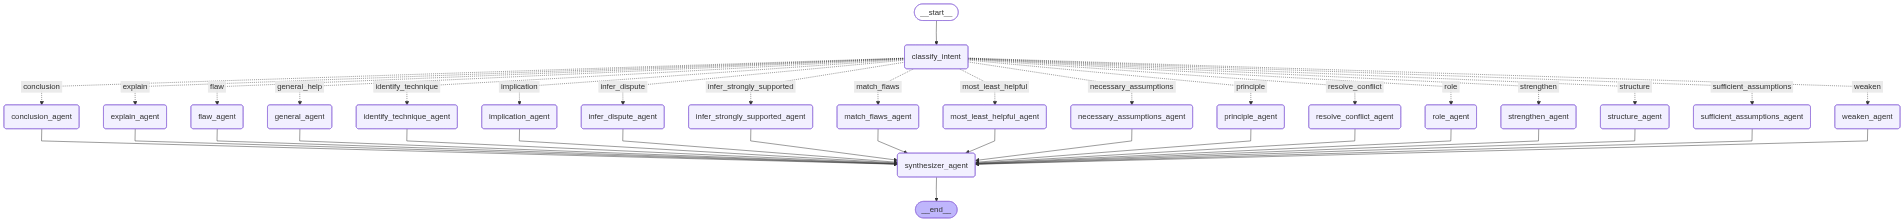

In [10]:
workflow

In [13]:
initial_state = {
        "passage": """(. . .) There are three other common drivers for carnivore-human attacks, some of which are more preventable than others. Natural aggression-based conflicts – such as those involving females protecting their young or animals protecting a food source – can often be avoided as long as people stay away from those animals and their food.
        Carnivores that recognise humans as a means to get food, are a different story. As they become more reliant on human food they might find at campsites or in rubbish bins, they become less avoidant of humans. Losing that instinctive fear response puts them into more situations where they could get into an altercation with a human, which often results in that bear being put down by humans. "A fed bear is a dead bear," says Servheen, referring to a common saying among biologists and conservationists.
        Predatory or predation-related attacks are quite rare, only accounting for 17% of attacks in North America since 1955. They occur when a carnivore views a human as prey and hunts it like it would any other animal it uses for food. (. . .)

        Then there are animal attacks provoked by people taking pictures with them or feeding them in natural settings such as national parks which often end with animals being euthanised out of precaution. "Eventually, that animal becomes habituated to people, and [then] bad things happen to the animal. And the folks who initially wanted to make that connection don't necessarily realise that," says Christine Wilkinson, a postdoctoral researcher at UC Berkeley, California, who's been studying coyote-human conflicts.

        After conducting countless postmortems on all types of carnivore-human attacks spanning 75 years, Penteriani's team believes 50% could have been avoided if humans reacted differently. A 2017 study co-authored by Penteriani found that engaging in risky behaviour around large carnivores increases the likelihood of an attack.
        Two of the most common risky behaviours are parents leaving their children to play outside unattended and walking an unleashed dog, according to the study. Wilkinson says 66% of coyote attacks involve a dog. "[People] end up in a situation where their dog is being chased, or their dog chases a coyote, or maybe they're walking their dog near a den that's marked, and the coyote wants to escort them away," says Wilkinson.

        Experts believe climate change also plays a part in the escalation of human-carnivore conflicts, but the correlation still needs to be ironed out. "As finite resources become scarcer, carnivores and people are coming into more frequent contact, which means that more conflict could occur," says Jen Miller, international programme specialist for the US Fish & Wildlife Service. For example, she says, there was an uptick in lion attacks in western India during a drought when lions and people were relying on the same water sources.

        (. . .) The likelihood of human-carnivore conflicts appears to be higher in areas of low-income countries dominated by vast rural landscapes and farmland, according to Penteriani's research. "There are a lot of working landscapes in the Global South that are really heterogeneous, that are interspersed with carnivore habitats, forests and savannahs, which creates a lot more opportunity for these encounters, just statistically," says Wilkinson.

        """,

        "user_query":"""   
        Which of the following statements, if false, would be inconsistent with the concerns raised in the passage regarding the drivers of carnivore-human conflicts?
        options:
        A) Climate change has had negligible effects on the frequency of carnivore-human interactions in affected regions.
        B) Carnivores lose their instinctive fear of humans when consistently exposed to human food sources.
        C) Predatory attacks by carnivores are a common occurrence and have steadily increased over the past few decades.
        D) Human efforts to avoid risky behaviors around large carnivores have proven effective in reducing conflict incidents.


                """
    }

final_state = workflow.invoke(initial_state)

📋 Classified Intent: Identify what is most/least helpful to know (difficulty: medium)
🎯 Intent in route based on intent function: Identify what is most/least helpful to know
🎯 Intent: Identify what is most/least helpful to know → Normalized: most_least_helpful → Routing to: most_least_helpful_agent
Running synthesiser agent
 intent in the synthesiser agent Identify what is most/least helpful to know


In [14]:
print(final_state.keys())
targeted_agent = list(final_state.keys())[-1]
print(final_state[targeted_agent])

dict_keys(['passage', 'user_query', 'intent_metadata', 'most_least_helpful_response'])
To address this question, we need to determine which statement, if false, would contradict the concerns raised in the passage about the drivers of carnivore-human conflicts.

---

**STEP 1: CLASSIFY QUESTION TYPE**

- This question is asking for a statement that, if false, would be inconsistent with the concerns raised in the passage.
- Rephrase: "Which statement, if false, would contradict the concerns about carnivore-human conflicts?"

---

**STEP 2: ARGUMENT ANALYSIS**

1. **Conclusion**: The passage discusses various drivers of carnivore-human conflicts and suggests that many of these conflicts could be avoided with different human behavior.
2. **Support**: The passage provides evidence of different types of conflicts, such as those caused by carnivores losing fear of humans due to food exposure, predatory attacks, and risky human behaviors.
3. **Gaps/Assumptions**: The passage assumes that human